-------------------------------------------------------------------------------
# **Time Series Forecasting**
-------------------------------------------------------------------------------

Time series forecasting with machine learning involves predicting future values of a time-dependent variable by learning from historical data patterns. 

This notebook mainly follows the tutorial on time series forecasting using TensorFlow presented in Ref. [1].

We'll try to explore the following:
1. Forecast for single time step:
    - Single feature
    - Multiple features
2. Forecast multiple steps:
    - Single shot: Make the predictions all at once
    - Autoregressive: Make one prediction at a time and feed the output back to the model.

Note: Main parts of the tutorial are directly lifted from Ref. [1].

References: <br>
[1] https://www.tensorflow.org/tutorials/structured_data/time_series <br>
[2] https://www.bgc-jena.mpg.de/wetter/

In [43]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

-------------------------------------------------------------------------------
#### **1. Data Preparation**
-------------------------------------------------------------------------------

We will use a *weather time series dataset* recorded by the Max Planck Institute for Biogeochemistry [2].
- This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity.
- These were collected every 10 minutes, beginning in 2003.

For efficiency, we will use only the data collected between 2009 and 2016.

In [44]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

Let's take a look at the dataset.

In [45]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


We'll perform sub-sampling to have hourly predictions rather than using the 10-minute interval.

In [ ]:
# Slice [start:stop:step], starting from index 5 take every 6th record.
# index 5 means 6*10mins or the first hour
# then every 6 steps will return the next hours
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S') # Return "Date Time" column and drop it from frame
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Let's now plot the evolution of few features over time.
- air temperature ("T (degC)")
- atmospheric pressure ("p (mbar)")
- humidity ("rho (g/m**3)")

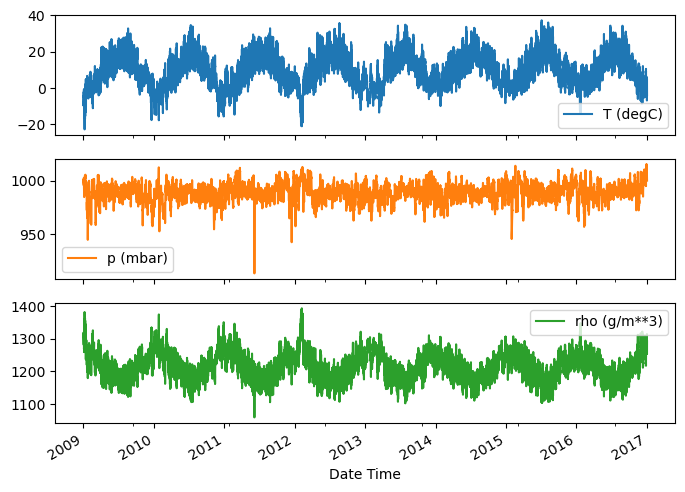

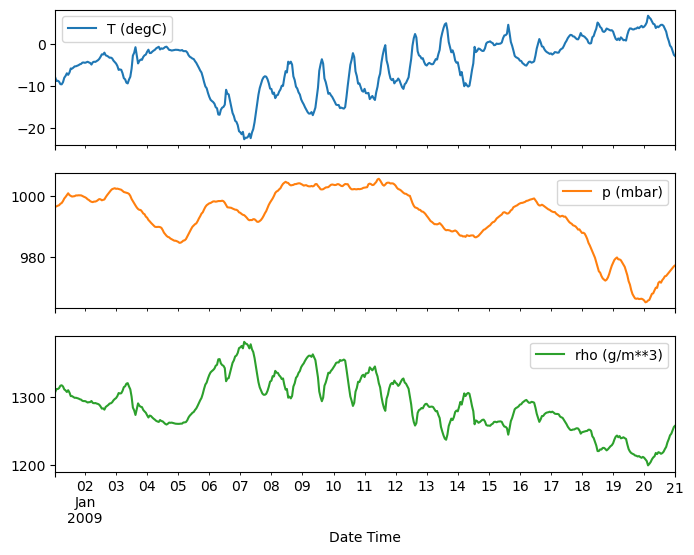

In [47]:
# plot all available data
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time # gives labels that identify each row
_ = plot_features.plot(subplots=True)

# plot a range of data (first 480 entries)
plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

-------------------------------------------------------------------------------
#### **1.1 Clean the data**
-------------------------------------------------------------------------------

Exploring further, let's examine the statistics of the hourly dataset.

In [48]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


Notice that the minimum value (min) of the wind velocity (wv (m/s)) and max. wind velocity (max. wv (m/s)) shows a value of -9999.00.

Assuming that the values in the original dataset was not altered in the sub-sampling process earlier, the -9999.00 value is an inherent error in the dataset. Hence, we need to correct them and "clean" the data.

Referring to the wind direction column, we find that the minimum wd(deg) is zero. It follows that the wind velocity should be greater than zero.

In [49]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.00
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.00
max_wv[bad_max_wv] = 0.0

Let's now check the cleaned data.

In [50]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


-------------------------------------------------------------------------------
#### **1.2 Feature Engineering**
-------------------------------------------------------------------------------

We want to make sure that we are passing appropriately formatted data to the model.

Notice that the wind direction (wd (deg)) in the dataset is given in units of degrees. Let's look on the distribution of wind data.

Text(0, 0.5, 'Wind Velocity [m/s]')

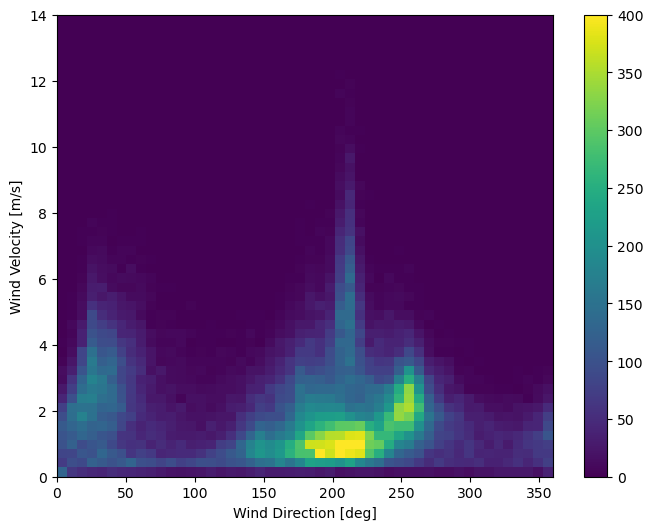

In [52]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

Direction should not matter if the wind is not blowing. It will be easier for the model to interpret the data if we convert the wind direction and wind velocity columns into a single wind vector column.

In [53]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')
wd_rad = df.pop('wd (deg)') * np.pi / 180 # convert deg to rad

# calculate the vector components
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

We now have the distribution of wind vectors.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

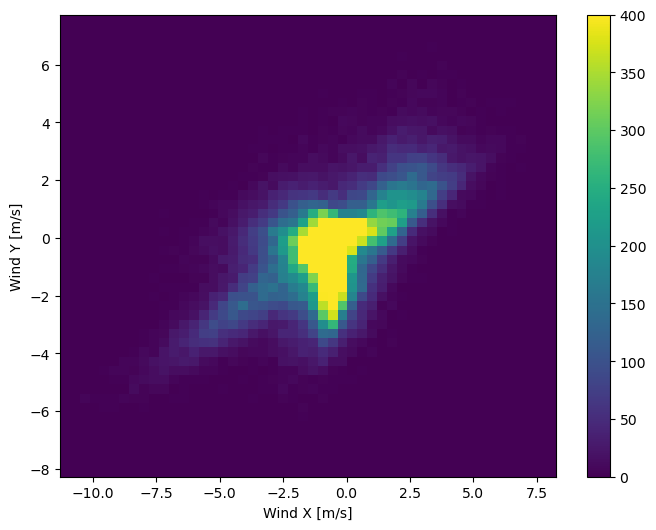

In [54]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

Now, let's take a look at the date_time column that we extracted earlier.

In [56]:
print(date_time)

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]


The data type datetime64[ns] in Python (specifically in the pandas library) represents a datetime object at nanosecond precision. We proceed by converting this to Unix timestamp format expressed in seconds.

Similar to the wind direction feature, the current form of the date_time feature is not a useful model input.

Considering that our dataset comes from weather data, we expect daily and yearly periodicity. Features like time of day (hours, minutes) or time of year (days, months) are cyclical. For example:
- 23:59 is very close to 00:00.
- December 31 is very close to January 1.

A numerical encoding (e.g., 1 to 12 for months) would not capture this cyclical relationship.

We then use sine and cosine transforms to get usable inputs from the "time of day" and "time of year" features.

In [57]:
# dtype: datetime64[ns] to Unix timestamp in seconds
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60 # 24 hours * 60 mins * 60 seconds
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Let's now check how the transformed feature looks like.

Let's visualize the cyclic nature of a 24-hour day.
- The sine wave (Day sin) will start at 0, rise to 1 (midday), drop back to 0, then to -1 (midnight), and return to 0 (completing one day).
- The cosine wave (Day cos) will start at 1 (midnight), drop to 0 (6 AM), reach -1 (midday), rise back to 0 (6 PM), and return to 1.

Text(0.5, 1.0, 'Time of day signal')

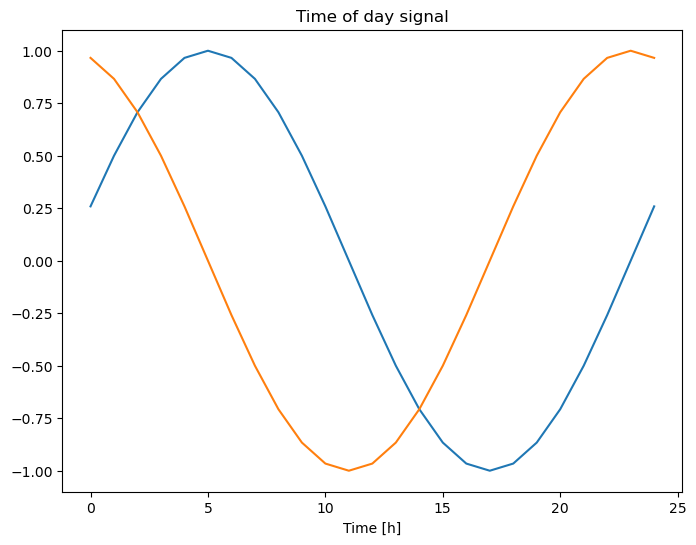

In [58]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This transformation gives the model access to the most important frequency features, i.e., periodicity of day and year.

If we don't know ahead of time which frequency features are important, we can determine them by extracting features with Fast Fourier Transform.

To check our assumption on the date_time as the important frequency feature, here is the tf.signal.rfft of the temperature over time.

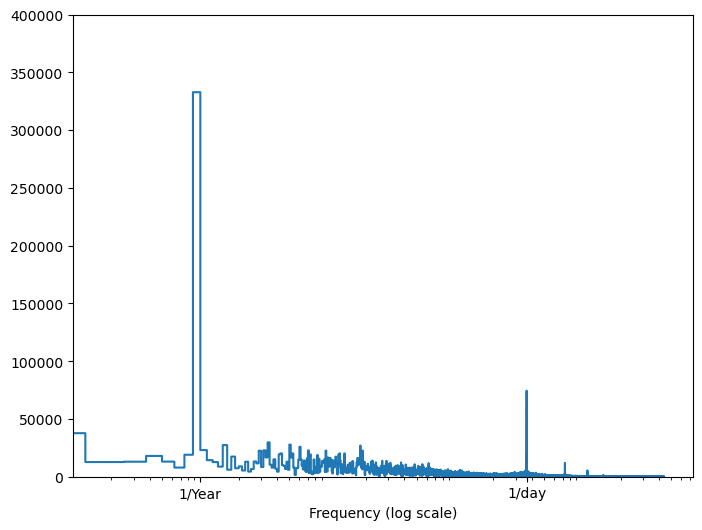

In [ ]:
# convert the time-domain signal (T (degC) over time)
# into its frequency-domain representation
fft = tf.signal.rfft(df['T (degC)']) # computes the real-valued FFT

# create an array of indices corresponding to the frequency bins of the FFT output.
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)']) # total no. of hourly T samples
hours_per_year = 24*365.2425
years_per_dataset = n_samples_h / hours_per_year

# converts the FFT frequency bins (f_per_dataset)
# into frequencies expressed as cycles per year.
f_per_year = f_per_dataset / years_per_dataset

plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim(0.1, max(plt.xlim()))
plt.xticks([1, 365.2425], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

Notice the obvious peaks at frequencies near 1/year and 1/day.

Peaks in the plot correspond to strong periodic signals in the temperature data.
- A peak at 1/Year (1 cycle per year) indicates yearly variation (e.g., seasons).
- A peak at 1/Day (365.2524 cycles per year) indicates daily variation (e.g., day-night cycles).

After gathering and cleaning our dataset, we are now ready to proceed to the next step.

-------------------------------------------------------------------------------
#### **2. Train-Test Split**
-------------------------------------------------------------------------------

We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. **Note the data is not being randomly shuffled before splitting**. This is for two reasons:
- It ensures that chopping the data into windows of consecutive samples is still possible.
- It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [62]:
# create a dictionary of column indices
# keys are coulumn names, values are the respective indices
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1] # number of features

Before proceeding, we need to scale the features before training a model.

Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

Note that the mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using *moving averages*. However, that is not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity we will only use a simple average.

In [63]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now, let's take a look into the normalized dataset.

Again, normalization ensures the data has a mean of 0 and a standard deviation of 1, which is useful for many machine learning algorithms and visualizations.

In [72]:
df_std = (df - train_mean) / train_std
df_std.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,0.067069,1.007402,-9.045695,-0.537073,0.110113,0.730784,3.209854
T (degC),70091.0,0.039547,0.973245,-3.682079,-0.665308,0.034869,0.736202,3.254992
Tpot (K),70091.0,0.034170,0.974747,-3.707266,-0.659613,0.030378,0.726100,3.210987
Tdew (degC),70091.0,0.051184,0.965263,-4.216645,-0.625277,0.087546,0.786027,2.647686
rh (%),70091.0,0.006269,0.995143,-3.746587,-0.646076,0.205009,0.815084,1.455361
VPmax (mbar),70091.0,0.028783,1.005867,-1.609554,-0.725833,-0.199500,0.552963,6.551868
VPact (mbar),70091.0,0.042062,0.994154,-2.030996,-0.745429,-0.118091,0.713606,4.489514
VPdef (mbar),70091.0,0.009233,1.016773,-0.829861,-0.649279,-0.375291,0.270240,8.720259
sh (g/kg),70091.0,0.040809,0.994220,-2.022853,-0.746298,-0.121123,0.706204,4.550843
H2OC (mmol/mol),70091.0,0.040860,0.994086,-2.031986,-0.745617,-0.118865,0.709763,4.524268


As we can see, after normalization, the mean is approximately zero and the sample standard deviation is approximately 1.

Now, let's visualize the normalized dataset.

C:\Users\HP\AppData\Local\Temp\ipykernel_21360\2514414550.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


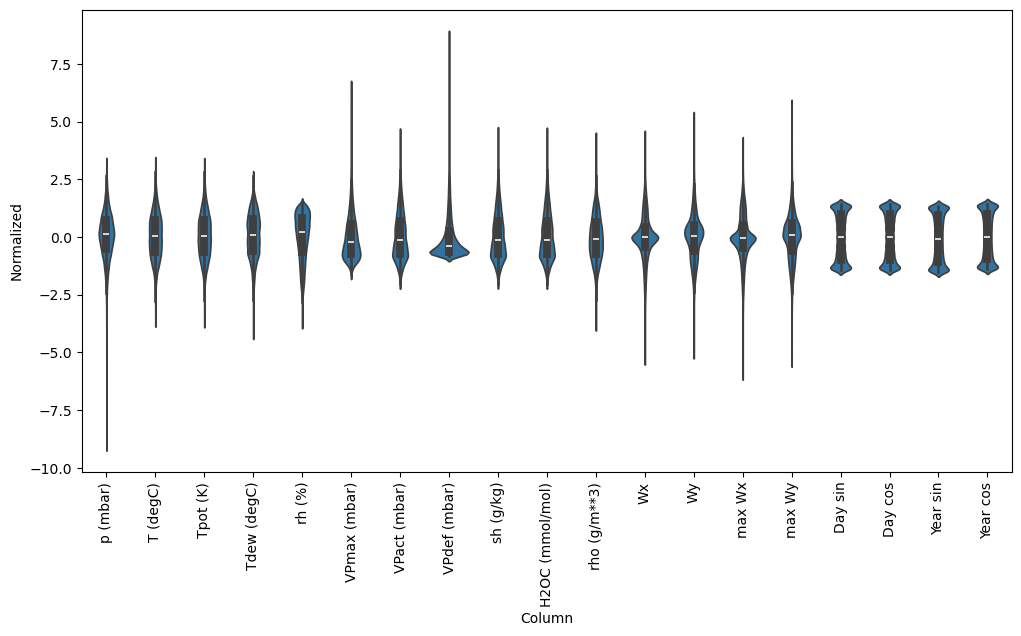

In [73]:
# Converts the DataFrame from a wide format (columns for each feature)
# to a long format (2 columns: column names and normalized values).

df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

The violin plot shows the distribution of the data (similar to a boxplot) but also includes the density curve, giving more insight into the data distribution.

-------------------------------------------------------------------------------
#### **2.1 Data windowing**
-------------------------------------------------------------------------------

The models in this tutorial will make a set of predictions based on a *window of consecutive samples* from the data.

The main features of the input windows are:
- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both.

We now focus on implementing the data windowing so that it can be reused for all of the models in this tutorial (including Linear, DNN, CNN and RNN models).

Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction of 24 hours into the future, given 24 hours of history, you might define a window like this:
<br><br>
![future_24hr](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. A model that makes a prediction of one hour into the future, given six hours of history, would need a window like this:
<br><br>
![future_1hr](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

We now follow the tutorial to define a WindowGenerator class. This class can:
- Handle the indexes and offsets as shown in the diagrams above.
- Split windows of features into (features, labels) pairs.
- Plot the content of the resulting windows.
- Efficiently generate batches of these windows from the training, evaluation, and test data, using tf.data.Datasets.

In [74]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # work out the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
        # work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])

Let's try to illustrate the examples mentioned earlier.

1. Windowing for a single prediction of 24 hours into the future, given 24 hours of history:

In [77]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

2. Windowing for a prediction of one hour into the future, given six hours of history:

In [78]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

-------------------------------------------------------------------------------
#### **Summary**
-------------------------------------------------------------------------------

Here’s a general guide to time series forecasting using machine learning:

**1. Data Preparation**
- Collect Data: Gather historical time series data.
- Explore and Clean Data: Handle missing values, outliers, and make sure data is correctly formatted with consistent time intervals.
- Feature Engineering: Extract useful features like time-based components (day of the week, seasonality), lagged values (previous time steps), moving averages, and other derived variables.

**2. Train-Test Split**
- Divide the data into a training set and a test set. For time series, split chronologically (e.g., using the first 80% of data for training and the last 20% for testing).
- Avoid shuffling the data, as maintaining the order is crucial for time series prediction.

**3. Choose a Machine Learning Model**
- Autoregressive Models (AR, ARIMA): Traditional statistical models that are powerful for univariate time series with seasonality or trend patterns.
- Linear Regression and Ridge/Lasso Regression: Can be used with lagged variables and engineered features to predict the next time step.
- Tree-Based Models (Random Forest, XGBoost, LightGBM): Suitable for handling nonlinear relationships and complex interactions in time series. Adding time-based features like month, day, or lagged values can enhance performance.
- Neural Networks:
    - Recurrent Neural Networks (RNN), LSTM, and GRU: Good for sequential data; LSTM and GRU are particularly effective at learning long-term dependencies.
    - Convolutional Neural Networks (CNN): Can be used with time series by treating the data as a sequence. Often combined with LSTM (CNN-LSTM models).
    - Transformer Models: Emerging in popularity for time series forecasting, especially with temporal attention mechanisms that capture dependencies.

**4. Train the Model**
- Hyperparameter Tuning: Perform cross-validation or use grid/random search for hyperparameters, especially for tree-based and neural network models.
- Sliding Window Approach: For each prediction, shift the training window forward by one time step to capture recent data trends. You can also use walk-forward validation for robust model assessment.

**5. Evaluate the Model**
- Metrics: Choose evaluation metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE) to assess model accuracy.
- Backtesting: Use backtesting techniques where the model predicts over multiple time windows to test its reliability on past data.

**6. Deploy the Model for Forecasting**
- After validation, deploy the model to forecast future data points.
- Automation: Set up periodic retraining to adapt to new data patterns as time progresses.
- Monitoring: Continuously monitor forecasting accuracy and recalibrate as needed.

**7. Advanced Techniques**
- Ensemble Models: Combine multiple models to capture various patterns in the data.
- Hybrid Models: Use statistical methods (e.g., seasonal decomposition) to remove seasonality and then apply machine learning on the residuals.
- Deep Learning Architectures: Experiment with advanced architectures, such as attention mechanisms or Seq2Seq, to capture complex dependencies.